# Assignment 10: Data Bias

# Forming a Hypothesis
My Hypothesis: The Perspective API will be more likely to mark longer comments correctly for toxicity than shorter comments.
- Criteria: If the comment is less than 100 characters, mark as a short comment, else, mark as a long comment

# Perform imports and load the manually reviewed data

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
!pip install scikit-learn==1.2.1
import numpy as np
import pandas as pd
# Load manually reviewed data
sample_df = pd.read_csv("Sample_labeled_data.csv")
sample_df.head()

,Unnamed: 0,id,comment_text,toxic
0,5,0001ea8717f6de06,Thank you for understanding I think very highl...,no
1,7,000247e83dcc1211,Dear god this site is horrible,no
2,11,0002f87b16116a7f,Somebody will invariably try to add Religion ...,no
3,13,0003e1cccfd5a40a,It says it right there that it IS a type The...,no
4,14,00059ace3e3e9a53,Before adding a new product to the list mak...,no


# Extract the comment_text column from the sample dataframe

In [11]:
test_df_extract = sample_df[["comment_text"]]
test_df_extract.head()

,comment_text
0,Thank you for understanding I think very highl...
1,Dear god this site is horrible
2,Somebody will invariably try to add Religion ...
3,It says it right there that it IS a type The...
4,Before adding a new product to the list mak...


# Store the actual scores and map to 1 or 0 depending on yes or no
Grab 75 comments from the data, skipping each index by 50 for each comment in the dataset to randomly select and avoid biases.

In [12]:
toxic_actual = []
n = 0
X_test = test_df_extract
for count in range(0,len(X_test),50):
    if sample_df['toxic'][count] == 'yes':
        toxic_actual.append(1)
    else:
        toxic_actual.append(0)
    
    n+=1
    if n == 75:
        break

# Creating the Test set from the Perspective Machine Learning API

Similarly, get the same comments from the dataset, using the API to predict the toxicity of the comment.

In [15]:
from googleapiclient import discovery
import json
import os 
from dotenv import load_dotenv
# Get API key from .env file
load_dotenv('/Users/Zach Soo/I310D_DataBias/api.env')
API_KEY = os.environ.get("myapi")
# Build API
client = discovery.build( "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

n = 0
data = {'Comment': [],
        'Toxicity Score':[]}

for count in range(0,len(X_test),50):
    data['Comment'].append(X_test["comment_text"][count])
    
    analyze_request = {
      'comment': { 'text': X_test["comment_text"][count] },
      'requestedAttributes': {'TOXICITY': {}}
    }

    response = client.comments().analyze(body=analyze_request).execute()
    
    data['Toxicity Score'].append(response["attributeScores"]['TOXICITY']['summaryScore']['value'])
    
    n+=1
    if n == 75:
        break


df = pd.DataFrame(data)
df


,Comment,Toxicity Score
0,Thank you for understanding I think very highl...,0.016210
1,Another priceless gem from yourself demons...,0.397214
2,Thanks for your response Ill nominate them today,0.018598
3,You can keep reverting me to push your WPUndue...,0.159326
4,Will be editing the Andraka page Please cons...,0.018598
...,...,...
70,yes he shot himself in 1963 this article is te...,0.612239
71,It is well knwon that Jainism came from Bihar ...,0.054779
72,can mean all sorts of this it can mean your MU...,0.377512
73,The heading gives a context I really dont see ...,0.042162


# Load Test Dataset to csv

In [16]:
df.to_csv("APITestDataset.csv")

# Perform Descriptive Statistics on Test Dataset
I performed descriptive statistics on the test dataset to determine normality + distribution of the dataset.

In [17]:
api_df = pd.read_csv("APITestDataset.csv")
score = api_df["Toxicity Score"]
score.describe()

count    75.000000
mean      0.197836
std       0.237489
min       0.005623
25%       0.026382
50%       0.068963
75%       0.381988
max       0.829959
Name: Toxicity Score, dtype: float64

<AxesSubplot:>

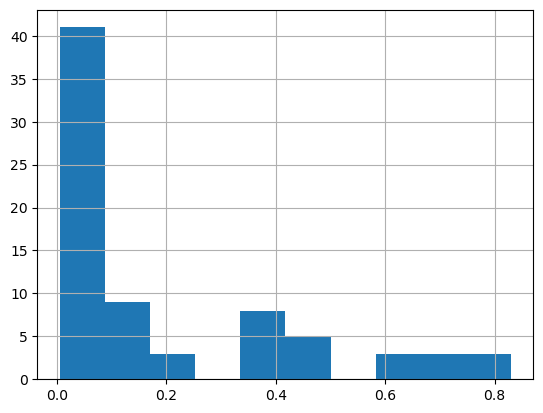

In [18]:
score.hist()

# Q: How does a low sample size impact your results, and the conclusions we can draw from them?

Having a low sample size(n=75) will impact my results due to the toxicity score distributions being skewed right upon looking at the histogram, which is not normal and conclusions drawn will be not necessarily representative of a larger population.

# Assessing fairness of the API with respect to comment length

If the comment length is greater than or equal to 100 characters, the comment will be classified as a long comment. If the comment length is less than 100 characters, the comment will be classified as a short comment. To answer the hypothesis, I first split the type of comment and scores into two dataframes, short comments and long comments.
- I output the number of short and long comments and printed their respective dataframes below.

In [19]:
comment_column = api_df["Comment"]

shortComment_indices = []
longComment_indices = []

longComments = []
longScores = []
shortComments = []
shortScores = []
longActual = []
shortActual = []

for i in range(len(api_df["Comment"])):
    if len(comment_column[i]) >= 100:
        longComment_indices.append(i)
        longComments.append(api_df["Comment"][i])
        longScores.append(api_df["Toxicity Score"][i])
        longActual.append(toxic_actual[i])
    else:
        shortComment_indices.append(i)
        shortComments.append(api_df["Comment"][i])
        shortScores.append(api_df["Toxicity Score"][i])
        shortActual.append(toxic_actual[i])
        
testLong_df = pd.DataFrame({'Long Comment':longComments,
                        'Predicted Score (from API)':longScores,
                        'Actual Score':longActual
})

testShort_df = pd.DataFrame({'Short Comment': shortComments,
                        'Predicted Score (from API)':shortScores,
                        'Actual Score':shortActual
})

print("Number of short comments:",len(shortComment_indices))
print("Number of long comments:",len(longComment_indices))

Number of short comments: 32
Number of long comments: 43


# Dataframe for short comments (viewing purposes)

In [20]:
testShort_df

,Short Comment,Predicted Score (from API),Actual Score
0,Thank you for understanding I think very highl...,0.016210,0
1,Thanks for your response Ill nominate them today,0.018598,0
2,Ive asked to discuss removals of information ...,0.037341,0
3,Noses I blow my nose in them,0.423492,0
4,Oh okay gotcha Sorry,0.013760,0
5,It would also be pleasant if everyone could ju...,0.026853,0
6,My mom hits me very very very very very very v...,0.401485,0
7,pls can you put a decent pic of him this one m...,0.751094,1
8,Here it is paragraphs 567 httpwwwcnncom2009TE...,0.077668,0
9,scale disclosure where multiple patients are a...,0.023200,0


# Dataframe for long comments  (viewing purposes)

In [21]:
testLong_df

,Long Comment,Predicted Score (from API),Actual Score
0,Another priceless gem from yourself demons...,0.397214,0
1,You can keep reverting me to push your WPUndue...,0.159326,0
2,Will be editing the Andraka page Please cons...,0.018598,0
3,OMG Hallelujah Ive seen the light Youre absol...,0.411684,0
4,solve this problem it would be much appreciate...,0.048100,0
5,A question to WWGB I added Berthe Meijer on...,0.081625,0
6,Hello to be honest software corporations aren...,0.025910,0
7,UAA Holding Pen question Had a questions ...,0.068963,0
8,Im working on a rewrite but Im finding this ...,0.023435,0
9,While we use different headers preparation usu...,0.014954,0


# Determining classwise accuracies for long comments and short comments 
As same as the actual score, where we mapped yes and no to 1 and 0, do the same to the toxicity scores by following a threshold.
- Threshold: If API predicted toxicity score is in the range of (0,0.5], map to not toxic (assign 0). If API predicted toxicity score is in the range of (0.5,1), map to toxic (assign 1) 

In [22]:
# Threshold: 0 < score <= 0.5 --> not toxic (assign 0), 0.5 < score < 1 --> toxic (assign 1) 
toxic_map_predicted = []
for index in range(len(api_df["Toxicity Score"])):
    if api_df["Toxicity Score"][index] <=0.5:
        toxic_map_predicted.append(0)
    else:
        toxic_map_predicted.append(1)

accuracy = accuracy_score(toxic_map_predicted,toxic_actual)
print (f"Accuracy of the classifier = {accuracy}")

toxic_actual_longComment = [toxic_actual[i] for i in longComment_indices]
toxic_predicted_longComment = [toxic_map_predicted[i] for i in longComment_indices]

toxic_actual_shortComment = [toxic_actual[i] for i in shortComment_indices]
toxic_predicted_shortComment = [toxic_map_predicted[i] for i in shortComment_indices]

Accuracy of the classifier = 0.96


In [23]:
def class_wise_acc(toxic_actual, toxic_predicted):
    total_p = 0
    total_n = 0
    TP=0
    TN=0
    
    for i in range(len(toxic_predicted)):
        if toxic_actual[i]==1:
            total_p = total_p+1
            if toxic_actual[i]==toxic_predicted[i]:
               TP=TP+1
        if toxic_actual[i]==0:
            total_n=total_n+1
            if toxic_actual[i]==toxic_predicted[i]:
               TN=TN+1
    return(TP/total_p, TN/total_n)

class_1_acc_longComment, class_0_acc_longComment = class_wise_acc(toxic_actual_longComment, toxic_predicted_longComment)
class_1_acc_shortComment, class_0_acc_shortComment = class_wise_acc(toxic_actual_shortComment, toxic_predicted_shortComment)

print (f"Class 1 (i.e., predicted toxicity score > 0.5) accuracy for Long Comments = {class_1_acc_longComment}")
print (f"Class 0 (i.e., predicted toxicity score <= 0.5) accuracy for Long Comments = {class_0_acc_longComment}")
print (f"Class 1 (i.e., predicted toxicity score > 0.5) accuracy for Short Comments = {class_1_acc_shortComment}")
print (f"Class 0 (i.e., predicted toxicity score <= 0.5) accuracy for Short Comments = {class_0_acc_shortComment}")


Class 1 (i.e., predicted toxicity score > 0.5) accuracy for Long Comments = 0.5
Class 0 (i.e., predicted toxicity score <= 0.5) accuracy for Long Comments = 1.0
Class 1 (i.e., predicted toxicity score > 0.5) accuracy for Short Comments = 1.0
Class 0 (i.e., predicted toxicity score <= 0.5) accuracy for Short Comments = 0.9230769230769231


# Explaining Methods and Results


The approach I took was a classwise analysis approach, where predicted scores from the Perspective API are classified 0 (no toxicity) or 1 (toxicity) based on the threshold that predicted scores equal or less than 0.5 are classified 0, while predicted scores that are greater than 0.5 are classified 1. The reason why I took this approach was because it would allow me to easily separate the long and short comments and gauge their accuracies regarding toxicity of the comment separately. 

Upon testing the API and accessing fairness within my test dataset of n = 75, I found that my Hypothesis was false, because my tests reported that the Perspective API was less accurate in marking long comments than short comments for toxicity. The class 1 accuracy for between long comments and short comments had a difference of 50% accuracy, and the API was found to be more accurate in detecting toxicity for short comments than long comments. Overall, this showed that the API was more biased towards short comments than long comments when detecting toxicity.

I was surprised that my hypothesis was disproven, because I felt that the API would be more accurate in flagging longer comments for toxicity than shorter comments, due to more information, but this was not the case. I feel the reason why shorter comments were more accurate than longer comments is because I feel that a source of bias comes from a lack of testing with the API with longer comments (100 character+ comments) as opposed to shorter comments.

From this assignment, I learned how to access an API and extract data from a dataset with an API. I also learned how to assess areas of a test dataset for possible bias, by classifying toxicity scores, computing classwise accuracies, and analyzing them. Lastly, I learned how to store my API key securely through dot env files.